<a href="https://colab.research.google.com/github/shobhitsundriyal/Revisit_ML/blob/master/bert_sentiment_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams # check whats this
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict 

from textwrap import wrap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#l load the Google Play app reviews dataset

!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 40.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0.5, 0, 'Review Score')

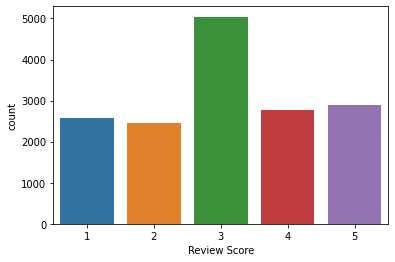

In [7]:
sns.countplot(df.score)
plt.xlabel('Review Score')

In [0]:
def score2sentiment(x):
  if x <= 2:
    return 0 #Negetive
  elif x == 3:
    return 1 #Neutral
  else:
    return 2 #Positive

In [0]:
df['sentiment'] = df.score.apply(score2sentiment)
class_name = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

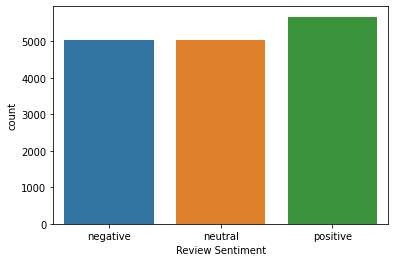

In [10]:
ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_name)

quite blanced dataset

## Data Preprocessing

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
sample_text = 'this is Bert classification notebook. And I will use Pytorch'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [13]:
print(
     f'Sentence: {sample_text}\n Tokens: {tokens} \n Token-Id: {token_ids}'
)

Sentence: this is Bert classification notebook. And I will use Pytorch
 Tokens: ['this', 'is', 'Bert', 'classification', 'notebook', '.', 'And', 'I', 'will', 'use', 'P', '##yt', '##or', '##ch'] 
 Token-Id: [1142, 1110, 15035, 5393, 17189, 119, 1262, 146, 1209, 1329, 153, 25669, 1766, 1732]


Maybe pytorch is not in vocab

In [14]:
# [SEP] - marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [15]:
# [CLS] - to idicate bert we are doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [16]:
# '[PAD]' - for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [17]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens = True, # cls, pad, etc
    return_token_type_ids=False,
    pad_to_max_length = True,
    return_attention = True,
    return_tensors = 'pt' #return Pytorch tensors 
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
len(encoding['input_ids'][0])

32

In [19]:
encoding['input_ids'][0]

tensor([  101,  1142,  1110, 15035,  5393, 17189,   119,  1262,   146,  1209,
         1329,   153, 25669,  1766,  1732,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [20]:
encoding['input_ids'].shape

torch.Size([1, 32])

In [21]:
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'][0])
encoding['attention_mask'].shape

32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


torch.Size([1, 32])

In [22]:
# inverse the tokenization to have a look at the special tokens

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'this',
 'is',
 'Bert',
 'classification',
 'notebook',
 '.',
 'And',
 'I',
 'will',
 'use',
 'P',
 '##yt',
 '##or',
 '##ch',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Text(0.5, 0, ' ')

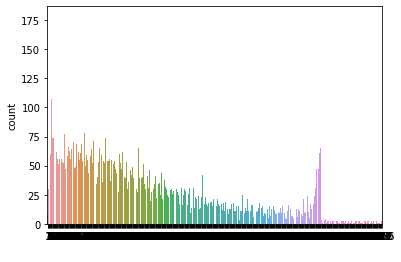

In [34]:
sns.countplot(df.content.str.len())
plt.xlabel(' ')

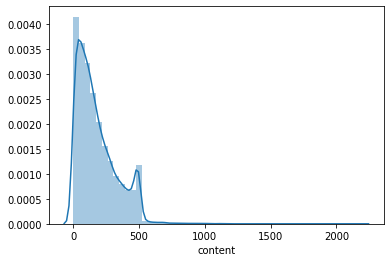

In [35]:
sns.distplot(df.content.str.len())

In [29]:
df.content.map(len).max() #¯\_(ツ)_/¯

2176

Max length of content is somewhere around 115, and bert max_length is 512so everything is good

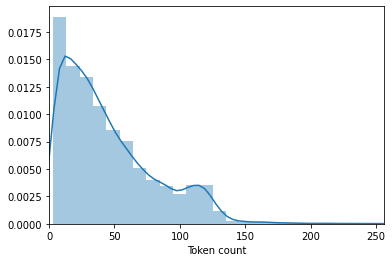

In [31]:
token_lens = []

for text in df.content:
  tokens = tokenizer.encode(text, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

---Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a
maximum length of 160.---

In [0]:
MAX_LENGTH = 160